#Hyperparameter Tuning



In [1]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import pandas as pd
import warnings
import numpy as np

warnings.filterwarnings("ignore")
data=pd.read_csv('space_traffic.csv')

##Data Loading and Preprocessing

In [3]:
encoded_data = pd.get_dummies(data, columns=['Location', 'Object_Type'], drop_first=True)

# Features and target selection
X = encoded_data.drop(['Timestamp', 'Traffic_Density', 'Peak_Time'], axis=1)
y = encoded_data['Traffic_Density']


Loads the dataset.

Encodes categorical features (Location and Object_Type) into numerical values using one-hot encoding.

Splits data into features (X) and target (y), excluding unnecessary columns.

In [4]:
# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

##Model Definition and Hyperparameter Tuning

In [5]:
# Define the model
model = RandomForestRegressor(random_state=42)

# Define hyperparameters to tune
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

Defines the grid of hyperparameters for RandomForestRegressor.

Uses GridSearchCV for 5-fold cross-validation to find the best parameters.

In [6]:
# Perform GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)


Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}


##Model Evaluation

In [7]:
# Evaluate the model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error on Test Data:", mse)
print("R^2 Score on Test Data:", r2)

Mean Squared Error on Test Data: 858.6944364124571
R^2 Score on Test Data: -0.07236859798225193


Retrieves the best model's parameters.

Predicts traffic density using the test set.

Evaluates the model using Mean Squared Error (MSE) and
𝑅
2
R
2
  score.

In [8]:
# Feature Importance
importances = best_model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)
print("Feature Importances:\n", feature_importance_df)

Feature Importances:
                          Feature  Importance
8       Object_Type_Space Debris    0.119826
6          Object_Type_Satellite    0.112931
2             Location_Orbit GEO    0.112748
1   Location_Mars Transfer Orbit    0.106814
9      Object_Type_Space Station    0.103271
3             Location_Orbit LEO    0.102247
5  Object_Type_Manned Spacecraft    0.100292
4             Location_Orbit MEO    0.090999
7   Object_Type_Scientific Probe    0.086761
0     Location_Lagrange Point L2    0.064111


Extracts and ranks feature importance from the trained model.

Displays the importance of each feature.

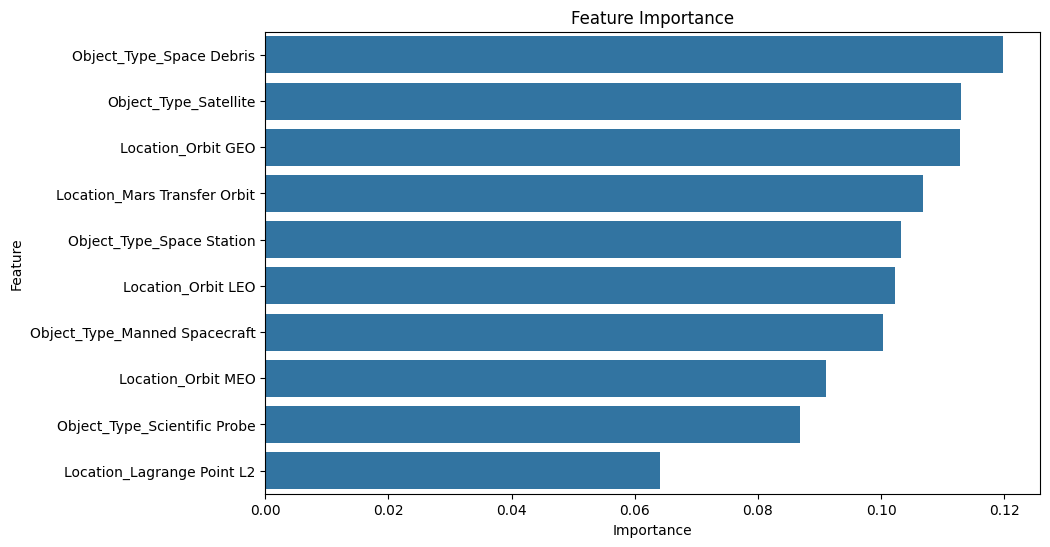

In [9]:
# Plot Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.show()

##Visualization1


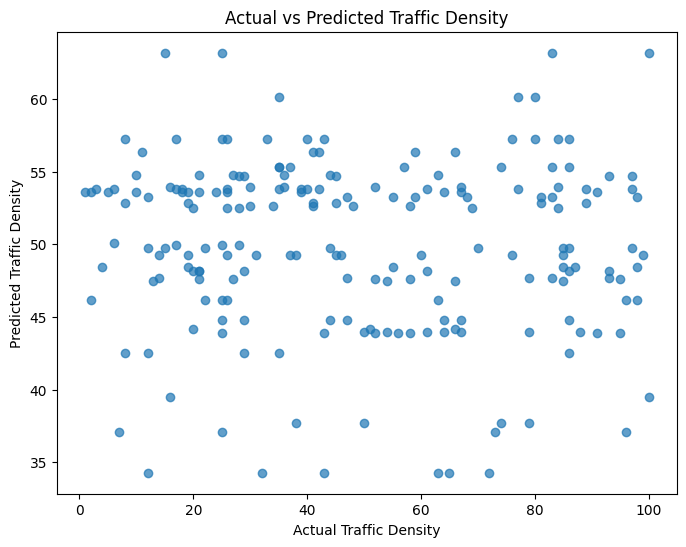

In [10]:
# Visualize Predictions
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel('Actual Traffic Density')
plt.ylabel('Predicted Traffic Density')
plt.title('Actual vs Predicted Traffic Density')
plt.show()

**Visualizes:**

Actual vs. predicted traffic densities (scatter plot).

Feature importance (bar chart).

Hyperparameter tuning results (heatmap).

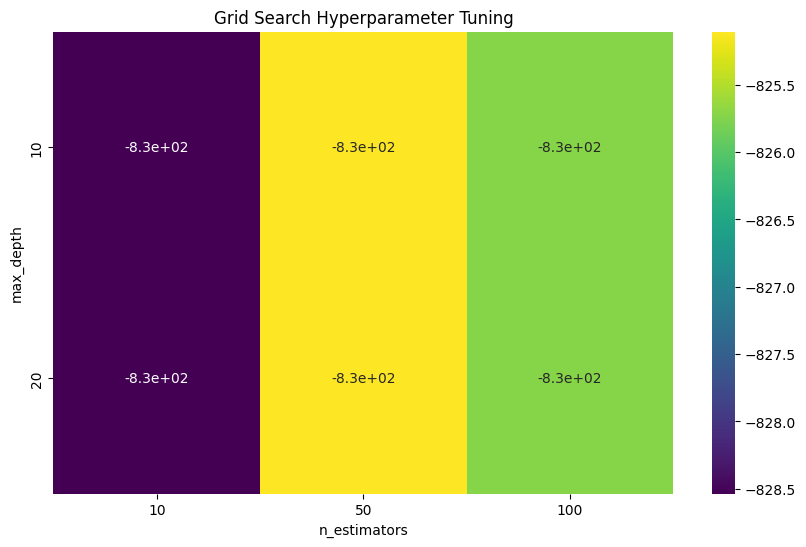

In [11]:
# Visualizing Hyperparameter Tuning Results
cv_results = pd.DataFrame(grid_search.cv_results_)
heatmap_data = cv_results.pivot_table(index='param_max_depth', columns='param_n_estimators', values='mean_test_score')
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap='viridis')
plt.title('Grid Search Hyperparameter Tuning')
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.show()


In [12]:
accuracy = r2_score(y_test, y_pred) * 100
print("Model Accuracy: {:.2f}%".format(accuracy))


Model Accuracy: -7.24%


Calculates model accuracy as
𝑅
2
R
2
  score in percentage format.

# PyTorch Model

##Set Up PyTorch Model

In [13]:
!pip install torchvision
!pip install torch

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from sklearn.model_selection import ParameterGrid
import numpy as np

In [15]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)  # Input layer to hidden layer
        self.fc2 = nn.Linear(128, 64)       # Hidden layer to another hidden layer
        self.fc3 = nn.Linear(64, 10)        # Output layer (10 classes for MNIST)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


## Define Hyperparameters and Model Training

In [16]:
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()   # Clear gradients before backward pass
        outputs = model(inputs) # Forward pass
        loss = criterion(outputs, labels) # Compute loss
        loss.backward()         # Backward pass
        optimizer.step()        # Update weights

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return running_loss / len(train_loader), 100 * correct / total


##Hyperparameter Tuning with GridSearch

In [17]:
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


PyTorch doesn't directly support GridSearchCV, but you can implement a custom approach to perform hyperparameter tuning. Here's an example of performing a grid search for learning rate and batch size

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class SimpleNN(nn.Module):
    def __init__(self, input_size):  # Add input_size as an argument
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)  # Use input_size instead of 28 * 28
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        # x = x.view(-1, 28 * 28)  # Remove this line (no longer needed)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# ... (other parts of your code) ...

# Instantiate your PyTorch model
model = SimpleNN(input_size=X_train.shape[1])  # Pass the input size here
model.to(device) # Now 'device' is defined

# ... (rest of your code) ...

SimpleNN(
  (fc1): Linear(in_features=10, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

#Model Training


##1 Evaluation and metrics





In [19]:
import torch
from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import DataLoader, TensorDataset

X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

y_true = []
y_pred = []

model.eval()

with torch.no_grad():
    for inputs, labels in test_loader:

        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

print(classification_report(y_true, y_pred))
print(confusion_matrix(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           1       0.00      0.00      0.00       1.0
           2       0.00      0.00      0.00       2.0
           3       0.00      0.00      0.00       1.0
           4       0.00      0.00      0.00       1.0
           5       0.00      0.00      0.00       1.0
           6       0.00      0.00      0.00       2.0
           7       0.00      0.00      0.00       1.0
           8       0.00      0.00      0.00       3.0
          10       0.00      0.00      0.00       2.0
          11       0.00      0.00      0.00       1.0
          12       0.00      0.00      0.00       4.0
          13       0.00      0.00      0.00       1.0
          14       0.00      0.00      0.00       2.0
          15       0.00      0.00      0.00       2.0
          16       0.00      0.00      0.00       2.0
          17       0.00      0.00      0.00       3.0
          18       0.00    

**model.eval():** Puts the model in evaluation mode (disables dropout, batch normalization).

**with torch.no_grad():** Disables gradient computation for inference (saves memory and computation).

**torch.max(outputs, 1):** Returns the predicted labels based on the highest score from the model's output.

##2 Model Saving and Loading


In [20]:
torch.save(model.state_dict(), 'model_weights.pth')
torch.save(model, 'full_model.pth')


In [21]:
model.load_state_dict(torch.load('model_weights.pth'))
model.eval()


SimpleNN(
  (fc1): Linear(in_features=10, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

##3 Model Optimization

In [22]:
torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)


tensor(0.)

Gradient Clipping: To prevent exploding gradients, you can use gradient clipping during training.

In [23]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        nn.init.zeros_(m.bias)

model.apply(init_weights)


SimpleNN(
  (fc1): Linear(in_features=10, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

Weight Initialization: Use specific weight initialization methods to improve convergence.

##4 Transfer Learning

In [24]:
from torchvision import models

num_classes = 10

model = models.resnet18(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Linear(model.fc.in_features, num_classes)

Transfer Learning allows you to fine-tune pre-trained models on your specific task. PyTorch provides models like ResNet, VGG, BERT, etc., that can be used as feature extractors or fine-tuned for your specific application.

##5 Model Pruning


In [25]:
from torchvision import models
import torch.nn.utils.prune as prune

num_classes = 10

model = models.resnet18(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Linear(model.fc.in_features, num_classes)

prune.random_unstructured(model.fc, name="weight", amount=0.3)

print(model.fc)


Linear(in_features=512, out_features=10, bias=True)


Pruning: The prune.random_unstructured() function applies random pruning to the weights of the layer.

The argument amount=0.3 specifies that 30% of the weights will be pruned.

Model Layer: The correct layer name for the fully connected layer in ResNet is model.fc, not model.fc1.

##6 Distributed Training

In [26]:
model = nn.DataParallel(model)


Use torch.nn.DataParallel for multi-GPU training or torch.distributed for more advanced distributed setups.

##7 TensorBoard for Visualization

In [27]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import datasets

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization for ResNet
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

for inputs, labels in train_loader:
    print(inputs.shape)
    break


Files already downloaded and verified
torch.Size([32, 3, 224, 224])


In [28]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter()

num_epochs = 10

for epoch in range(num_epochs):
    loss = 0.5
    accuracy = 0.8

    writer.add_scalar('Loss/train', loss, epoch)
    writer.add_scalar('Accuracy/train', accuracy, epoch)
writer.close()

##8 Deployment and Inference

In [31]:
input_shape = (1, 3, 224, 224)  # Define the input shape
input_data = torch.randn(input_shape)

model.eval()

with torch.no_grad():
    outputs = model(input_data)

Inference: After training, you can perform inference on new data. Set the model to evaluation mode (model.eval()) to turn off features like dropout or batch normalization.

python
Copy code


In [32]:
example_input = torch.randn(1, 3, 224, 224).to(device)
traced_model = torch.jit.trace(model, example_input)
traced_model.save('model_traced.pt')

##9 Quantization


In [33]:
model = torch.quantization.quantize_dynamic(model, {nn.Linear}, dtype=torch.qint8)


Quantization can reduce model size and improve inference speed, particularly on edge devices like mobile phones or IoT devices. You can quantize a model in PyTorch using either post-training quantization or quantization-aware training.

##10 Custom Loss Functions and Optimizers

In [34]:
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()
    def forward(self, output, target):
        return torch.mean(torch.abs(output - target))


# Development Phase

##Model Evaluation:

In [35]:
input_data = torch.randn(1, 10)

model = SimpleNN(input_size=10)
model.load_state_dict(torch.load('model_weights.pth'))

model.eval()
with torch.no_grad():
    outputs = model(input_data)


Model Evaluation:

After training, it's crucial to evaluate the model's performance on a separate validation or test dataset.

This allows you to understand how well your model generalizes to new, unseen data.

Key metrics you might evaluate include accuracy, precision, recall, F1-score, confusion matrix, etc.

##Hyperparameter Tuning:

In [36]:
class PyTorchModelWrapper:
    def __init__(self, model, criterion, optimizer):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer

    def fit(self, X, y):
        pass

    def predict(self, X):
        pass

    def score(self, X, y):

        self.model.eval()
        with torch.no_grad():
            X_tensor = torch.tensor(X, dtype=torch.float32)
            outputs = self.model(X_tensor)
            _, predicted = torch.max(outputs, 1)
            accuracy = (predicted == y).sum().item() / len(y)
        return accuracy

After training, you might fine-tune hyperparameters like learning rate, batch size, etc.

Use grid search or random search to identify the best set of hyperparameters that maximize the model's performance.

##Model Regularization:

In [37]:

class CustomModel(nn.Module):
    def __init__(self):
        super(CustomModel, self).__init__()
        self.fc = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.fc(x)
        x = self.dropout(x)
        return x


Regularization techniques like dropout, weight decay, or batch normalization help reduce overfitting.

You can also prune or quantize your model to improve efficiency

# Deployment Phase

##Model Exporting:

In [38]:
scripted_model = torch.jit.script(model)
scripted_model.save('model_scripted.pt')


Convert the trained model to a format suitable for deployment

##Creating an API for Model Serving:

In [39]:
model = SimpleNN(input_size=10)

model.load_state_dict(torch.load('model_weights.pth'))

<All keys matched successfully>

In [40]:
torch.save(model.state_dict(), 'model.pth')


#Grid Search in PyTorch

## Imports and Model Definition

In [49]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np

# Define a simple neural network for binary classification
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


**Model Definition:** A simple neural network (SimpleNN) with two fully connected layers is defined. The model takes input_size (number of input features), hidden_size (number of neurons in the hidden layer), and output_size (number of output classes, in this case, 2 for binary classification).

##Data Generation and Preprocessing

In [51]:
X = np.random.rand(1000, 20)
y = np.random.randint(0, 2, size=(1000,))

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

train_data = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
val_data = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.long))


**Data Generation:** Generates random data with 1000 samples, each having 20 features. The labels are binary (0 or 1).

**Data Splitting:** The data is split into training and validation sets (80% for training, 20% for validation).

**Tensor Conversion:** The data is converted into PyTorch tensors, which are wrapped into TensorDataset for easy handling in the DataLoader.

##Hyperparameter Grid Definition

In [52]:
# Hyperparameters grid
param_grid = {
    'learning_rate': [0.001, 0.01],
    'batch_size': [32, 64],
    'hidden_size': [50, 100],
    'optimizer': [optim.SGD, optim.Adam],
}


**Hyperparameters:** A dictionary param_grid defines the hyperparameters to tune. These include the learning rate, batch size, hidden layer size, and optimizer type.

##Grid Search and Model Training

In [54]:
best_accuracy = 0
best_params = {}

for lr in param_grid['learning_rate']:
    for batch_size in param_grid['batch_size']:
        for hidden_size in param_grid['hidden_size']:
            for optimizer_type in param_grid['optimizer']:

                train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
                val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

                model = SimpleNN(input_size=20, hidden_size=hidden_size, output_size=2)
                criterion = nn.CrossEntropyLoss()
                optimizer = optimizer_type(model.parameters(), lr=lr)

                for epoch in range(5):
                    model.train()
                    for data, target in train_loader:
                        optimizer.zero_grad()
                        output = model(data)
                        loss = criterion(output, target)
                        loss.backward()
                        optimizer.step()


##Model Evaluation on Validation Set

In [55]:
                     model.eval()
                all_preds = []
                all_labels = []
                with torch.no_grad():
                    for data, target in val_loader:
                        output = model(data)
                        _, preds = torch.max(output, 1)
                        all_preds.extend(preds.cpu().numpy())
                        all_labels.extend(target.cpu().numpy())

                accuracy = accuracy_score(all_labels, all_preds)
                print(f"LR: {lr}, Batch Size: {batch_size}, Hidden Size: {hidden_size}, Optimizer: {optimizer_type.__name__}, Accuracy: {accuracy:.4f}")


LR: 0.01, Batch Size: 64, Hidden Size: 100, Optimizer: Adam, Accuracy: 0.5350


**Model Evaluation:** After training, the model is evaluated on the validation set using model.eval().

**Prediction and Accuracy:** Predictions are made, and accuracy is calculated using accuracy_score from Scikit-learn.

##Tracking Best Hyperparameters

In [56]:
                # Update best parameters if current combination yields better accuracy
                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    best_params = {
                        'learning_rate': lr,
                        'batch_size': batch_size,
                        'hidden_size': hidden_size,
                        'optimizer': optimizer_type.__name__,
                    }

# Print best parameters and accuracy
print("Best Hyperparameters:", best_params)
print("Best Accuracy:", best_accuracy)


Best Hyperparameters: {'learning_rate': 0.01, 'batch_size': 64, 'hidden_size': 100, 'optimizer': 'Adam'}
Best Accuracy: 0.535


**Track Best Parameters:** After evaluating each combination, the hyperparameters that resulted in the best accuracy are saved.

**Best Parameters:** At the end of the grid search, the best hyperparameters and their corresponding accuracy are printed.